In [1]:
import numpy as np
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import time

# import functions for ODE parameter estimation
from model.diag_Gaussian import *


np.random.seed(123)

## Parameter estimation of ODE models: 

$$
\frac{d \mathbf{x}}{d t} = f(\mathbf{x}, t, \theta) 
$$
where $\mathbf{x}$ is a vector of state variables and $\theta$ is a vector of model parameters to be estimated from data 

## Define ODE (x, time, parameters)

In [75]:
# ode 
def system(x, t, params): 

    # unpack parameters
    K, pref, sigma, delta, mu, gamma = params
    
    # unpack variables
    od, pH = x 
           
    # coupled ODE for cells and environmental pH
    dod = od * (mu - od / K) * (jnp.exp(-(pH - pref)**2 / sigma) - delta) 
    dpH = gamma * od 
    
    return jnp.array([dod, dpH])  

# define transform function to constrain parameter values
def transform(params):
    
    # unpack params
    K, pref, sigma, delta, mu, gamma = params
    
    # take exp of strictly positive parameters
    K = 5.*jnp.exp2(K) 
    pref = jnp.exp2(pref)
    sigma = 100.*jnp.exp2(sigma)
    delta = jnp.exp2(delta)/10.
    mu = jnp.exp2(mu)
        
    return jnp.array([K, pref, sigma, delta, mu, gamma])

# # define transform function to constrain parameter values
# def transform(params):
    
#     # unpack params
#     K, pref, sigma, delta, mu, gamma = params
    
#     # take exp of strictly positive parameters
#     K = 5.*relu(K)
#     pref = relu(pref)
#     sigma = 100.*sigma**2
#     delta = relu(delta)/10.
#     mu = relu(mu)
        
#     return jnp.array([K, pref, sigma, delta, mu, gamma])

# define prior mean
# K, pref, sigma, delta, mu, gamma
prior_mean = jnp.array([5., 7., 100., 0., 1., 0.])

## Import data as a Pandas dataframe 

The dataframe must have a "Treatments" column that provides a unique identifier for each condition. The second column specifies the time point that observations were made. The following columns include the state variables.

In [30]:
# import data
df = pd.read_csv("Data/arc_allmono.csv").rename(columns={"Experiments":"Treatments"})
df

,Treatments,Time,pH,AC_OD,BA_OD,BC_OD,BL_OD,BT_OD,BV_OD,CC_OD,DF_OD,wt_OD,delarc_OD,parc-_OD,parc+_OD
0,AC_pH4_0,0,5.003232,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,AC_pH4_0,3,5.014134,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,AC_pH4_0,6,5.016297,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,AC_pH4_0,9,5.043927,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,AC_pH4_0,12,5.011965,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1219,parc+_pH9_2,0,8.132268,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010000
1220,parc+_pH9_2,3,8.040755,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.183878
1221,parc+_pH9_2,6,7.873923,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.026189
1222,parc+_pH9_2,9,7.745788,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.903504


In [65]:
df_AC = pd.concat([df_exp[['Treatments', 'Time', 'pH', 'AC_OD']] for exp_name, df_exp in df.groupby("Treatments") if "AC" in exp_name])
df_AC

,Treatments,Time,pH,AC_OD
0,AC_pH4_0,0,5.003232,0.010000
1,AC_pH4_0,3,5.014134,0.010000
2,AC_pH4_0,6,5.016297,0.010000
3,AC_pH4_0,9,5.043927,0.010000
4,AC_pH4_0,12,5.011965,0.010000
...,...,...,...,...
103,AC_pH9_2,3,7.583511,0.046036
104,AC_pH9_2,6,7.604837,0.449068
105,AC_pH9_2,9,7.339334,3.110981
106,AC_pH9_2,12,7.093441,5.010713


## Specify system state variables 

In [71]:
# names of species
species = ['AC_OD', 'pH']

# global parameters used in ODE
n_s = len(species)

## Instantiate the model with the ODE function, training dataframe, system variables, and initial parameter guess

In [72]:
# instantiate gLV fit 
ode_model = ODE(system = system, 
            transform = transform,
            dataframe = df_AC, 
            sys_vars = species, 
            prior_mean = prior_mean, 
            alpha=1., beta=1000.)

## Fit the parameter posterior

In [73]:
# fit to data 
t0 = time.time()
ode_model.fit_posterior_EM(n_sample_sgd=11, 
                           n_sample_hypers=100, 
                           n_sample_evidence=100, 
                           patience=3)

print("Elapsed time {:.2f}s".format(time.time()-t0))

Computing model evidence...


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 204.95it/s]


Log evidence: -180281.628
Updating hyperparameters...


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 463.59it/s]


Updating posterior...
Epoch 1, NEG ELBO: 120.661
Epoch 2, NEG ELBO: 120.195
Epoch 3, NEG ELBO: 119.710
Epoch 4, NEG ELBO: 119.306
Epoch 5, NEG ELBO: 118.889
Epoch 6, NEG ELBO: 118.498
Epoch 7, NEG ELBO: 118.102
Epoch 8, NEG ELBO: 117.689
Epoch 9, NEG ELBO: 117.312
Epoch 10, NEG ELBO: 116.913
Epoch 11, NEG ELBO: 116.547, Slope: -0.003
Epoch 12, NEG ELBO: 116.188, Slope: -0.003
Epoch 13, NEG ELBO: 115.766, Slope: -0.003
Epoch 14, NEG ELBO: 115.450, Slope: -0.003
Epoch 15, NEG ELBO: 115.019, Slope: -0.003
Epoch 16, NEG ELBO: 114.644, Slope: -0.003
Epoch 17, NEG ELBO: 114.254, Slope: -0.003
Epoch 18, NEG ELBO: 113.864, Slope: -0.003
Epoch 19, NEG ELBO: 113.500, Slope: -0.003
Epoch 20, NEG ELBO: 113.061, Slope: -0.003
Epoch 21, NEG ELBO: 112.696, Slope: -0.003
Epoch 22, NEG ELBO: 112.363, Slope: -0.003
Epoch 23, NEG ELBO: 111.984, Slope: -0.003
Epoch 24, NEG ELBO: 111.559, Slope: -0.003
Epoch 25, NEG ELBO: 111.162, Slope: -0.003
Epoch 26, NEG ELBO: 110.786, Slope: -0.003
Epoch 27, NEG ELBO:

/home/jcthompson5@ad.wisc.edu/Documents/Liu_et_al_2024/model/diag_Gaussian.py:480: RuntimeWarning: All-NaN slice encountered
  if np.nanmax(np.abs(grad_val)) < 1000:


Epoch 99, NEG ELBO: 96.887, Slope: -0.003
Epoch 100, NEG ELBO: 94.808, Slope: -0.005
Epoch 101, NEG ELBO: 95.050, Slope: -0.005
Epoch 102, NEG ELBO: 94.498, Slope: -0.006
Epoch 103, NEG ELBO: 94.823, Slope: -0.001
Epoch 104, NEG ELBO: 94.514, Slope: -0.002
Epoch 105, NEG ELBO: 95.132, Slope: -0.002
Epoch 106, NEG ELBO: 94.550, Slope: -0.003
Epoch 107, NEG ELBO: 96.479, Slope: -0.000
Epoch 108, NEG ELBO: 93.769, Slope: -0.001
Epoch 109, NEG ELBO: 94.211, Slope: -0.000
Epoch 110, NEG ELBO: 94.160, Slope: -0.001
Epoch 111, NEG ELBO: 93.767, Slope: -0.001
Epoch 112, NEG ELBO: 94.604, Slope: -0.001
Epoch 113, NEG ELBO: 94.234, Slope: -0.001
Epoch 114, NEG ELBO: 94.254, Slope: -0.001
Epoch 115, NEG ELBO: 94.115, Slope: -0.001
Epoch 116, NEG ELBO: 94.821, Slope: -0.001
decrease lr to 1.722e-03
Epoch 117, NEG ELBO: 94.410, Slope: 0.001
decrease lr to 1.550e-03
Epoch 118, NEG ELBO: 94.853, Slope: 0.001
decrease lr to 1.395e-03
Epoch 119, NEG ELBO: 94.145, Slope: 0.001
decrease lr to 1.255e-03
E

100%|█████████████████████████████████████████| 100/100 [00:03<00:00, 32.96it/s]


Log evidence: -225.985
Updating hyperparameters...


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 480.08it/s]


Updating posterior...
Epoch 1, NEG ELBO: 95.720
Epoch 2, NEG ELBO: 95.530
Epoch 3, NEG ELBO: 95.749
Epoch 4, NEG ELBO: 94.955
Epoch 5, NEG ELBO: 95.342
Epoch 6, NEG ELBO: 94.744
Epoch 7, NEG ELBO: 94.435
Epoch 8, NEG ELBO: 94.873
Epoch 9, NEG ELBO: 94.221
Epoch 10, NEG ELBO: 94.581
Epoch 11, NEG ELBO: 94.122, Slope: -0.002
Epoch 12, NEG ELBO: 94.981, Slope: -0.001
Epoch 13, NEG ELBO: 93.968, Slope: -0.001
Epoch 14, NEG ELBO: 94.272, Slope: -0.001
Epoch 15, NEG ELBO: 94.080, Slope: -0.001
Epoch 16, NEG ELBO: 94.000, Slope: -0.001
Epoch 17, NEG ELBO: 94.334, Slope: -0.001
Epoch 18, NEG ELBO: 94.414, Slope: -0.000
Epoch 19, NEG ELBO: 94.080, Slope: -0.000
Epoch 20, NEG ELBO: 93.826, Slope: -0.000
Epoch 21, NEG ELBO: 94.750, Slope: -0.000
decrease lr to 9.000e-04
Epoch 22, NEG ELBO: 93.914, Slope: 0.000
decrease lr to 1.620e-03
Epoch 23, NEG ELBO: 94.240, Slope: 0.000
decrease lr to 1.458e-03
Epoch 24, NEG ELBO: 94.936, Slope: 0.001
decrease lr to 1.312e-03
Epoch 25, NEG ELBO: 94.271, Slop

100%|█████████████████████████████████████████| 100/100 [00:03<00:00, 29.65it/s]


Log evidence: -225.937
Updating hyperparameters...


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 452.17it/s]


Updating posterior...
Epoch 1, NEG ELBO: 85.600
Epoch 2, NEG ELBO: 85.628
Epoch 3, NEG ELBO: 85.395
Epoch 4, NEG ELBO: 85.739
Epoch 5, NEG ELBO: 85.617
Epoch 6, NEG ELBO: 85.071
Epoch 7, NEG ELBO: 85.886
Epoch 8, NEG ELBO: 84.839
Epoch 9, NEG ELBO: 85.533
Epoch 10, NEG ELBO: 85.588
Epoch 11, NEG ELBO: 79.561, Slope: -0.004
Epoch 12, NEG ELBO: 87.319, Slope: -0.002
Epoch 13, NEG ELBO: 85.184, Slope: -0.001
Epoch 14, NEG ELBO: 85.500, Slope: -0.001
decrease lr to 9.000e-04
Epoch 15, NEG ELBO: 85.918, Slope: 0.000
decrease lr to 1.620e-03
Epoch 16, NEG ELBO: 87.816, Slope: 0.002
decrease lr to 1.458e-03
Epoch 17, NEG ELBO: 85.123, Slope: 0.002
decrease lr to 1.312e-03
Epoch 18, NEG ELBO: 85.200, Slope: 0.002
decrease lr to 1.181e-03
Epoch 19, NEG ELBO: 85.022, Slope: 0.002
decrease lr to 1.063e-03
Epoch 20, NEG ELBO: 86.029, Slope: 0.003
Epoch 21, NEG ELBO: 78.278, Slope: -0.006
Epoch 22, NEG ELBO: 85.448, Slope: -0.004
Epoch 23, NEG ELBO: 85.605, Slope: -0.003
Epoch 24, NEG ELBO: 85.396,

100%|█████████████████████████████████████████| 100/100 [00:03<00:00, 28.42it/s]


Log evidence: -226.812
Updating hyperparameters...


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 474.83it/s]


Updating posterior...
Epoch 1, NEG ELBO: 93.713
Epoch 2, NEG ELBO: 93.961
Epoch 3, NEG ELBO: 93.710
Epoch 4, NEG ELBO: 94.192
Epoch 5, NEG ELBO: 93.844
Epoch 6, NEG ELBO: 93.059
Epoch 7, NEG ELBO: 94.096
Epoch 8, NEG ELBO: 92.982
Epoch 9, NEG ELBO: 92.948
Epoch 10, NEG ELBO: 94.142
Epoch 11, NEG ELBO: 93.584, Slope: -0.001
Epoch 12, NEG ELBO: 93.963, Slope: -0.000
decrease lr to 9.000e-04
Epoch 13, NEG ELBO: 94.186, Slope: 0.000
decrease lr to 1.620e-03
Epoch 14, NEG ELBO: 93.681, Slope: 0.001
decrease lr to 1.458e-03
Epoch 15, NEG ELBO: 93.692, Slope: 0.001
decrease lr to 1.312e-03
Epoch 16, NEG ELBO: 93.455, Slope: 0.000
decrease lr to 1.181e-03
Epoch 17, NEG ELBO: 93.416, Slope: 0.000
Epoch 18, NEG ELBO: 93.446, Slope: -0.000
Epoch 19, NEG ELBO: 86.989, Slope: -0.005
Epoch 20, NEG ELBO: 94.266, Slope: -0.003
Epoch 21, NEG ELBO: 95.902, Slope: -0.001
Epoch 22, NEG ELBO: 93.520, Slope: -0.000
decrease lr to 1.063e-03
Epoch 23, NEG ELBO: 93.354, Slope: 0.000
decrease lr to 9.566e-04
Ep

100%|█████████████████████████████████████████| 100/100 [00:03<00:00, 30.87it/s]


Log evidence: -225.998
Updating hyperparameters...


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 480.79it/s]


Updating posterior...
Epoch 1, NEG ELBO: 94.393
Epoch 2, NEG ELBO: 94.050
Epoch 3, NEG ELBO: 93.148
Epoch 4, NEG ELBO: 93.382
Epoch 5, NEG ELBO: 92.512
Epoch 6, NEG ELBO: 93.809
Epoch 7, NEG ELBO: 93.349
Epoch 8, NEG ELBO: 92.980
Epoch 9, NEG ELBO: 92.863
Epoch 10, NEG ELBO: 102.580
decrease lr to 9.000e-04
Epoch 11, NEG ELBO: 93.206, Slope: 0.003
decrease lr to 1.620e-03
Epoch 12, NEG ELBO: 93.504, Slope: 0.003
decrease lr to 1.458e-03
Epoch 13, NEG ELBO: 92.872, Slope: 0.002
decrease lr to 1.312e-03
Epoch 14, NEG ELBO: 94.045, Slope: 0.001
Epoch 15, NEG ELBO: 93.443, Slope: -0.000
Epoch 16, NEG ELBO: 92.565, Slope: -0.002
Epoch 17, NEG ELBO: 93.577, Slope: -0.002
Epoch 18, NEG ELBO: 92.983, Slope: -0.004
Epoch 19, NEG ELBO: 93.467, Slope: -0.005
Epoch 20, NEG ELBO: 93.305, Slope: -0.000
Epoch 21, NEG ELBO: 92.940, Slope: -0.000
decrease lr to 1.181e-03
Epoch 22, NEG ELBO: 93.635, Slope: 0.000
Epoch 23, NEG ELBO: 93.324, Slope: -0.000
decrease lr to 1.063e-03
Epoch 24, NEG ELBO: 93.27

100%|█████████████████████████████████████████| 100/100 [00:03<00:00, 29.66it/s]

Log evidence: -226.049
Elapsed time 33.67s


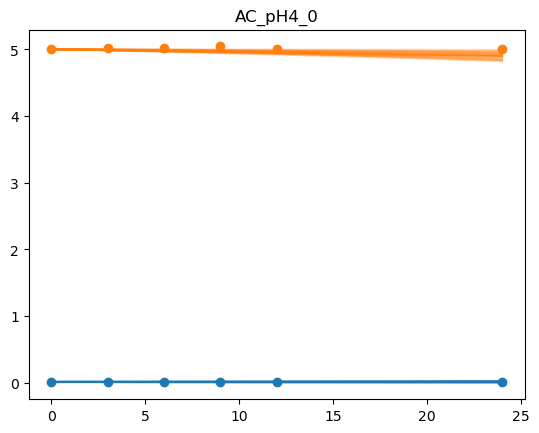

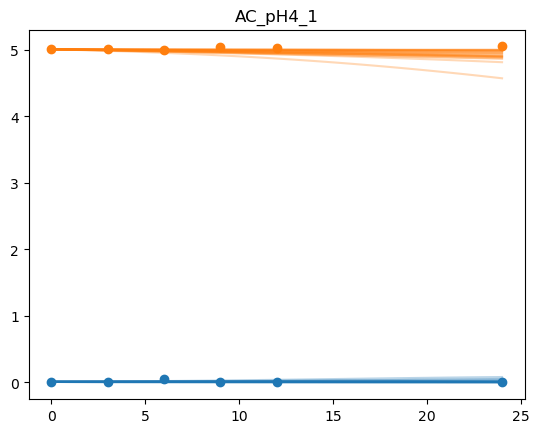

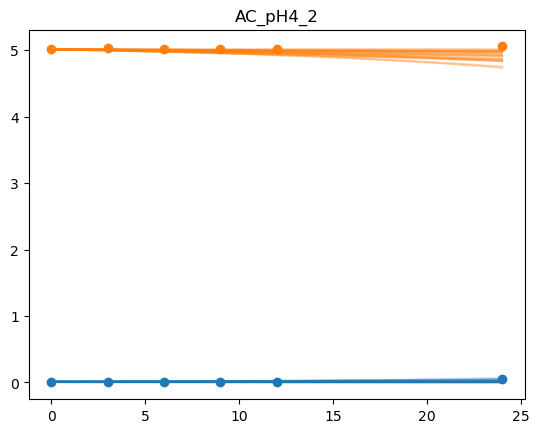

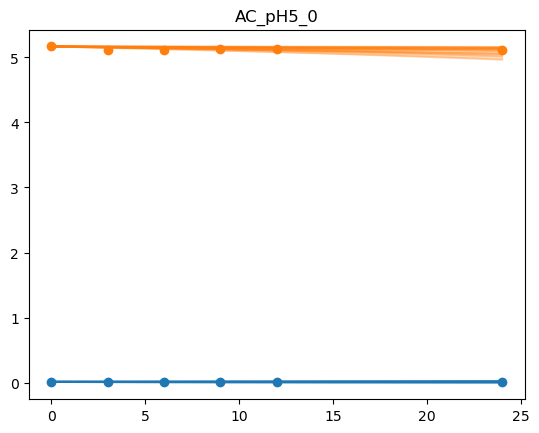

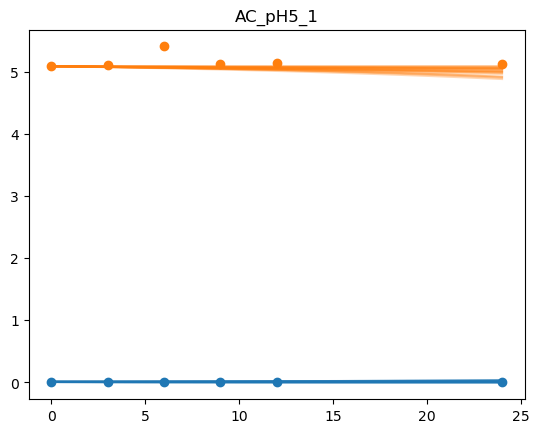

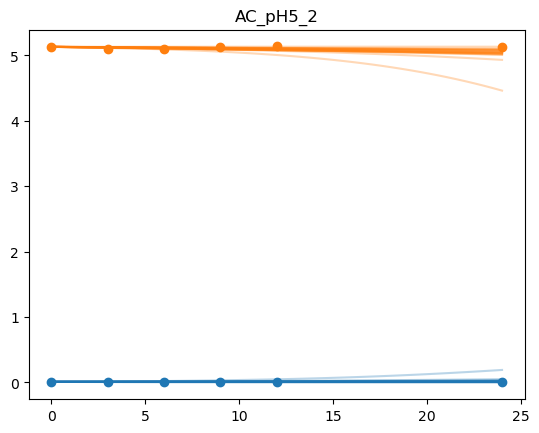

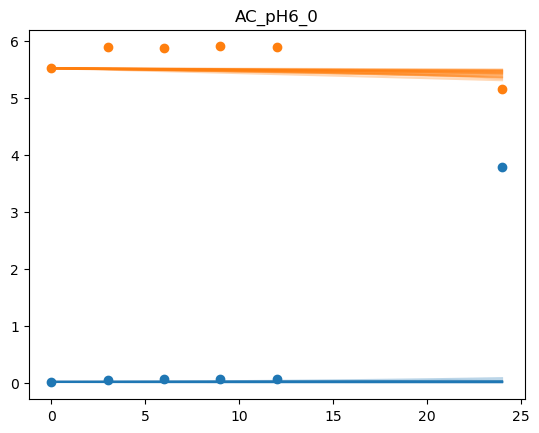

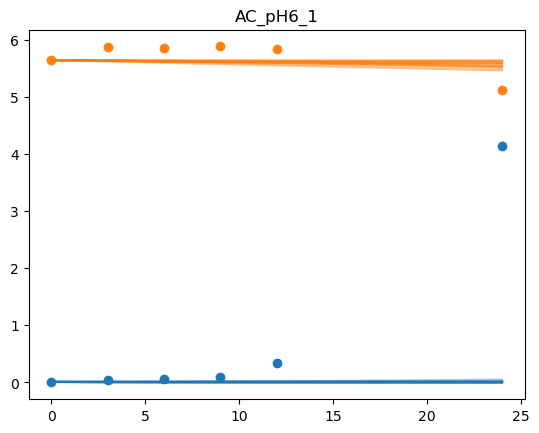

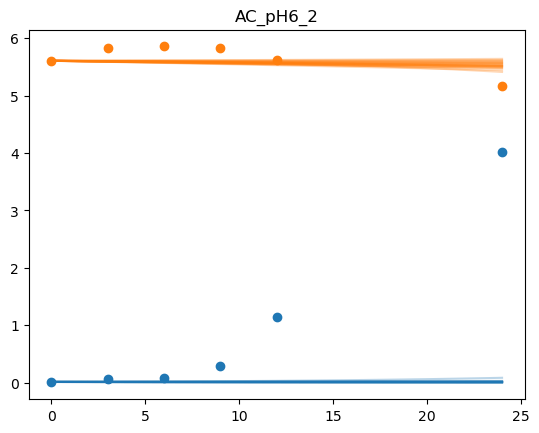

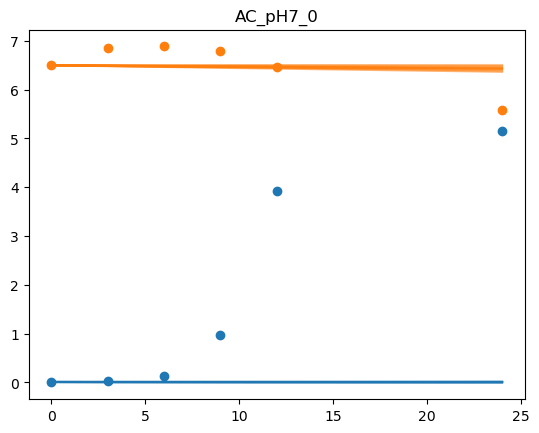

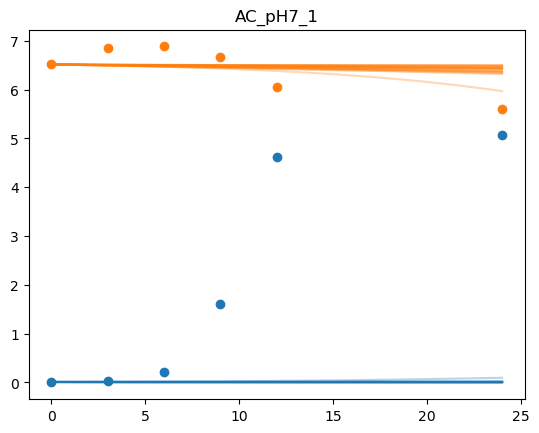

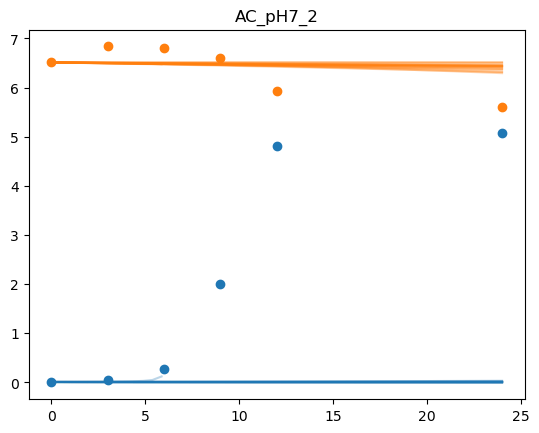

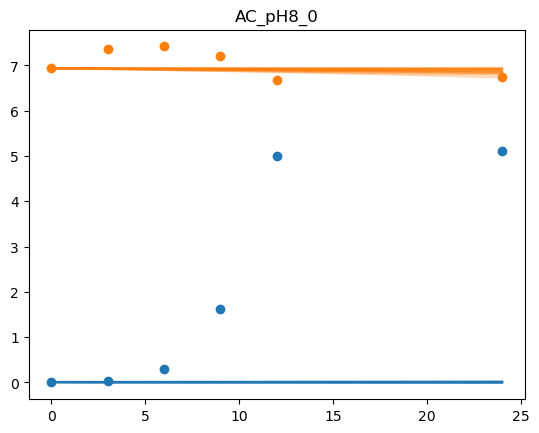

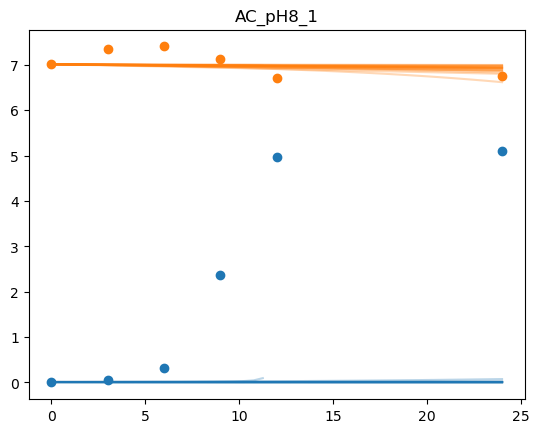

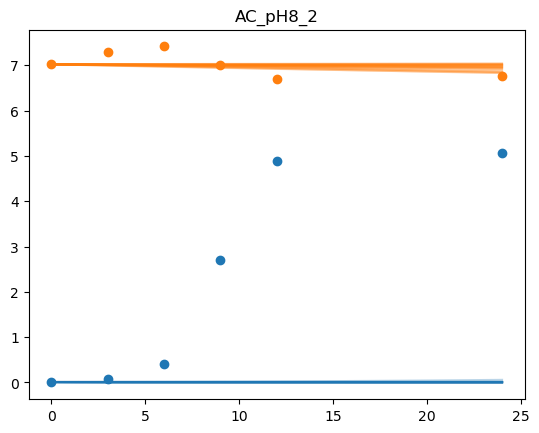

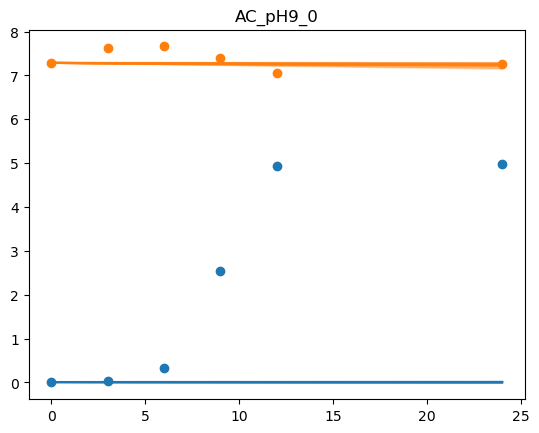

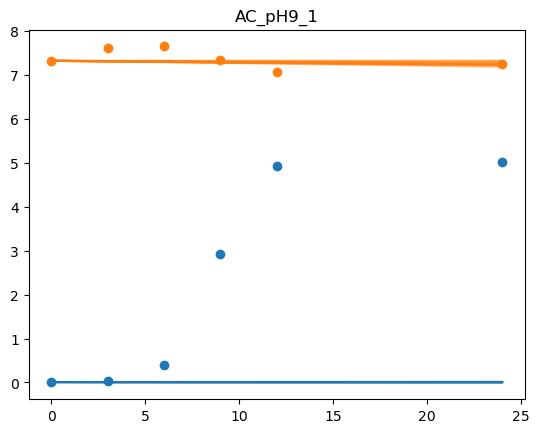

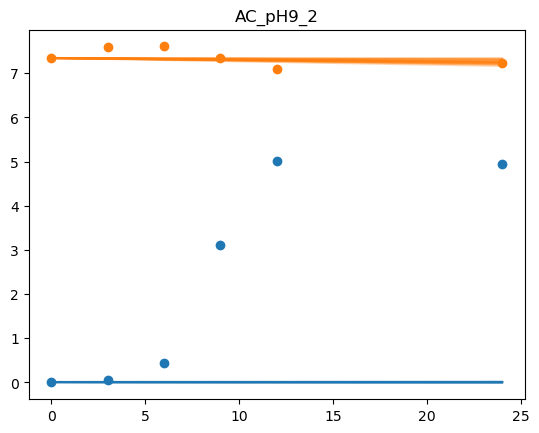

In [74]:
# random conditions to plot
plt_conditions = np.random.choice(np.unique(df.Treatments.values), 5, replace=False)

# for exp_name in plt_conditions:
for exp_name, exp_df in df_AC.groupby("Treatments"):
    # pull dataframe
    # exp_df = df.iloc[df.Treatments.values==exp_name].copy()
    
    # predict values
    x0 = exp_df[species].values[0]
    t_eval = np.linspace(0., max(exp_df.Time.values))
    y_preds = ode_model.predict_sample(x0, t_eval)
    
    # plot 
    for i, s in enumerate(species):
        plt.scatter(exp_df.Time.values, exp_df[s].values)
        for y_pred in y_preds:
            plt.plot(t_eval, y_pred[:, i], alpha=.3, c=f'C{i}')
    
    plt.title(exp_name)
    plt.show()

## Save parameter values

In [ ]:
# Define names of parameters 
df_params = ode_model.param_df()
df_params